In [1]:
import time
import numpy as np
import pandas as pd
import ringity as rng
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from itertools import product
from ipywidgets import widgets
from collections import Counter
from scipy.spatial.distance import squareform
from ringity.classes.network_model import NetworkBuilder

## Testing expected conditional probability and similairty

In [2]:
def expected_conditional_similarity(theta, rate, a):
    if np.isclose(rate, 0, atol=1e-7):
        return a
    
    if np.isclose(rate, np.inf):
        A = 1/(2*np.pi*a)
        B = A*np.pi
        C = B - 1
        return np.clip(np.abs(A*theta - B) - C, 0, 1)
    
    if theta < np.pi:
        if theta <= 2*np.pi*a:
            norm = 1 / (1 - np.exp(-2*np.pi*rate)) / (2*a*np.pi*rate)
            
            theta_term = -theta*rate * (1 - np.exp(-2*np.pi*rate))
            
            term1  = -2*np.exp(-rate*theta) + 1
            term21 =  np.exp(-rate*theta)*(np.exp(-2*a*np.pi*rate) + np.exp((2*a*np.pi - 2*np.pi)*rate))
            term22 = -np.exp(-2*np.pi*rate)
            
            return norm*(term1 + term21 + term22 + theta_term) + 1
        else:
            theta_term = np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
            alpha_term = (np.cosh(-rate*2*np.pi*a) - 1) / (a*np.pi*rate)
            return theta_term * alpha_term
        
    else:
        norm = 2*rate*np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
        
        def undef_int(t):
            return (np.exp(np.pi*rate)*(np.cosh((np.pi - t)*rate) + (-2*a*np.pi + t)*rate*np.sinh((np.pi - t)*rate)))/(2*a*np.pi*rate**2)
        
        if 2*np.pi - theta <= 2*np.pi*a:
            term1 = (-1 + np.cosh((2*np.pi - theta)*rate) + (2*(-1 + a)*np.pi + theta)*rate*np.sinh((2*np.pi - theta)*rate))/(2*a*np.pi*rate**2)
            term2 = undef_int(2*np.pi*a) - undef_int(2*np.pi - theta)
            return norm*term1 + norm*term2
        else:
            return norm*(np.sinh(a*np.pi*rate)**2)/(a*np.pi*rate**2)

In [3]:
def time_estimation(i, iter_len):
    TIME2 = time.time()
    t_cur = TIME2 - TIME1
    prog = (i+1)/iter_len
    t_rem = t_cur * (1/prog - 1)
    print(f"time passed: {t_cur:.2f}sec - progress: {100*prog:.2f}% - time remaining: {t_rem:.2f}sec",
          end = '\r')

In [4]:
n_a_samples = int(1.5*2**2)
n_b_samples = int(1.5*2**2)
n_k_samples = int(1.5*2**2)
n_n_samples = int(2**1)

a_arr = np.linspace(0.01, 0.5, n_a_samples)
b_arr = np.linspace(0.0, 1.0, n_b_samples)
k_arr = np.linspace(0.0, 1.0, n_k_samples)
n_arr = [2**(k+7) for k in range(n_n_samples)]

In [7]:
df_list = []

TIME1 = time.time()
count = 0
for alpha, beta, K, N in product(a_arr, b_arr, k_arr, n_arr):
    time_estimation(count, n_a_samples*n_b_samples*n_k_samples*n_n_samples)
    count += 1
    
    rate = rng.classes.network_model._get_rate_parameter(rate = None, beta = beta)
    scale = 1/rate if rate > 0 else np.inf

    random_positions = []

    position_generator = NetworkBuilder()
    position_generator.set_distribution('exponential', scale = scale)

    for _ in range(10):
        position_generator.instantiate_positions(N)
        random_positions.extend(position_generator.positions)

    deg_dist0_exp = [p for theta in random_positions
                       for p in np.random.binomial(N-1, K*expected_conditional_similarity(theta=theta, rate=rate, a=alpha), size=2**7)]
    degs_exp, freqs_exp = zip(*Counter(deg_dist0_exp).items())
    freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

    df_list.append(pd.DataFrame({'degree' : degs_exp,
                                 'frequency' : freqs_exp,
                                 'N' : N,
                                 'beta' : beta,
                                 'alpha' : alpha,
                                 'K' : K}
                               )
                  )

In [8]:
plot_df = pd.concat(df_list).sort_values('degree')

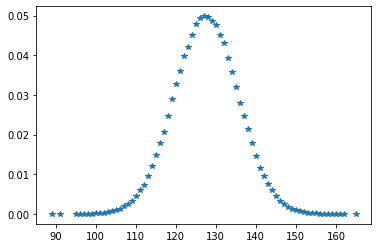

In [11]:
plt.plot(degs_exp, freqs_exp, '*')

Exectute the following code to save data

`for N, sub_df in plot_df.groupby('N'):
    sub_df = sub_df.drop('N', axis=1)
    sub_df[['beta', 'alpha', 'K']] = sub_df[['beta', 'alpha', 'K']].round(3)
    sub_df.to_csv(f"../../data/deg_dist/N_{N}.csv", index=False)`